# Sonification: Convert data to MIDI (Part 1)
This is a simple example of parameter mapping sonification in which discrete data points are mapped to musical notes. You can think of this as a musical scatter plot with time being the x-axis and musical pitch being the y-axis. This technique will likely be more intuitive when applied to time series data (since the 'x-axis' already indicates time) but it can be used no matter what the data on each axis represent. This is very similar to what can be done with software like [TwoTone](https://twotone.io) but of course it will be much more flexible when you do it yourself!  

As an example, we will recreate a version of the sonification method used in [Moon Impacts](www.system-sounds.com/moon-impacts/). We will start with a list of the lunar impact craters that are bigger than 10km across that have age estimates. This data comes from a paper by our friend Sara who discovered an interesting uptick in the impact rate about 290 million years ago [(Mazrouei et al 2019)](https://www.science.org/doi/10.1126/science.aar4058). The sonification will allow us to hear the rhythm of these large impacts over the last billion years. We'll map the crater diameters to pitch and velocity (a combinaiton of volume and intensity) so we can hear the distribution of impact sizes over time.

<br>
<div> <img src="figures/mapping.jpg" alt="Drawing" width="700"/></div>
<br>

The output of this notebook will be a MIDI file (.mid) which can be opened in any DAW (digital audio workstation) where you'll be able to choose any intrument or sound you want. 

The code is presented in many small steps with figures to be more accessible to beginners. If you're new to jupyter, you might want to check out [Jupyter notebook shortcuts](https://towardsdatascience.com/jypyter-notebook-shortcuts-bf0101a98330). If you're more advanced, you can start from a streamlined version of the algorithm that has been written as a single python script. 

In [part 2](https://astromattrusso.gumroad.com/l/data2music-part2), we'll go beyond pitch and velocity and will learn how to use data to control a vastly greater range of audio/musical parameters. 


## 1) Load data (.csv file)

In [2]:
import pandas as pd   #import library for loading data, https://pypi.org/project/pandas/

filename = 'lunarCraterAges'  #name of csv data file

df = pd.read_csv('../../data/' + filename + '.csv')  #load data as a pandas dataframe
#df = df[(df['diameter'] >= 20)] #filter data if you like (for example, only craters larger than 20km)

df = df.sort_values(by=['age'], ascending=False) #sort data from oldest to youngest (optional, doesn't affect the sonification)

n_impacts = len(df)
print(n_impacts, 'impacts')

df.head() #take a look at first 5 rows
#df.tail() #take a look at last 5 rows

111 impacts


,names,longitude,latitude,diameter,age
60,Mosting A,354.80469,-3.22070,12.7,1324
50,NaN,262.67029,43.65850,13.6,1026
45,NaN,79.73330,22.83180,14.3,993
2,King,120.49220,4.93750,76.2,992
41,Hume Z,90.41211,-3.62497,15.0,981


## 2) Plot data

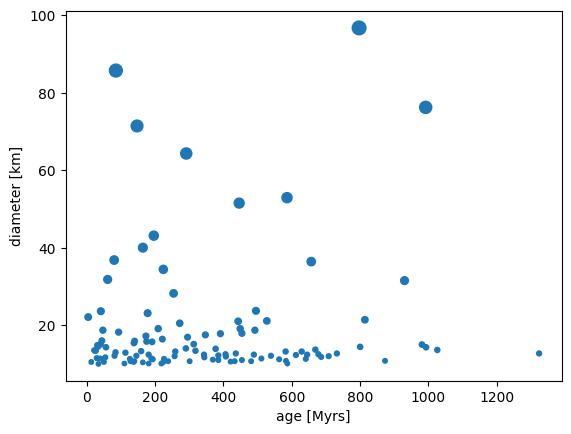

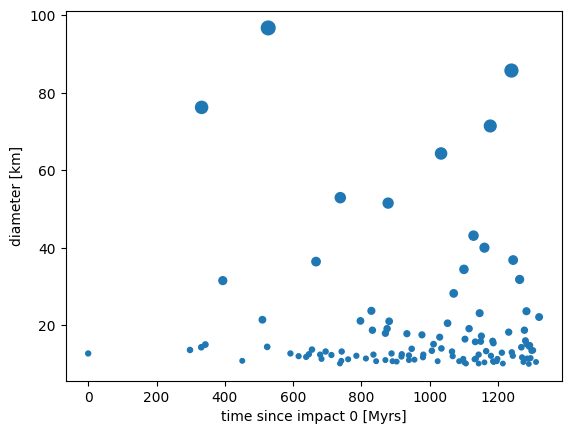

In [4]:
import matplotlib.pylab as plt  #import library for plotting, https://pypi.org/project/matplotlib/

ages = df['age'].values    #this is a numpy array (not a list), you can do mathematical operations directly on the object
diameters = df['diameter'].values 

plt.scatter(ages, diameters, s=diameters)
plt.xlabel('age [Myrs]')
plt.ylabel('diameter [km]')
plt.show()

times_myrs = max(ages) - ages  #measure time from oldest crater (first impact) in data

plt.scatter(times_myrs, diameters, s=diameters)
plt.xlabel('time since impact 0 [Myrs]')
plt.ylabel('diameter [km]')
plt.show()

## 3) Write general mapping function

In [5]:
def map_value(value, min_value, max_value, min_result, max_result):
    '''maps value (or array of values) from one range to another'''
    
    result = min_result + (value - min_value)/(max_value - min_value)*(max_result - min_result)
    return result

map_value(10, 1, 10, 100, 200)

200.0

## 4) Compress time
- the MIDI file we create will measure time in beats (quarter notes), not in seconds
- we'll set the tempo to 60 bpm so that 1 beat = 1 second so the distinction doesn't matter 
- for other projects you may want to quantize the data to some fraction of a beat (eigth note = 0.5 beat, etc.) and then be free to change the tempo

### option 1: set a conversion factor to compress time

In [7]:
myrs_per_beat = 25  #number of Myrs for each beat of music 

t_data = times_myrs/myrs_per_beat #rescale time from Myrs to beats

print(t_data)

duration_beats = max(t_data)  #duration in beats (actually, onset of last note)
print('Duration:', duration_beats, 'beats')



[ 0.   11.92 13.24 13.28 13.72 15.76 18.04 20.4  20.96 21.08 23.68 24.64
 25.52 25.84 26.2  26.68 27.16 27.32 27.8  28.48 29.48 29.52 29.64 29.68
 30.44 31.4  31.88 32.52 33.16 33.28 33.4  33.72 34.8  34.8  35.   35.12
 35.24 35.52 35.64 36.12 36.68 36.72 37.32 37.56 37.56 37.88 38.2  39.08
 39.2  39.24 40.24 40.44 40.92 41.16 41.32 41.36 42.08 42.6  42.68 42.8
 43.44 43.92 44.   44.04 44.12 44.24 44.6  45.12 45.24 45.32 45.4  45.72
 45.72 45.84 45.96 46.04 46.4  46.4  46.6  47.08 47.16 47.36 47.4  47.44
 47.48 47.84 47.92 48.44 48.56 49.24 49.56 49.6  49.72 49.76 50.52 50.72
 50.8  50.96 51.08 51.2  51.32 51.36 51.4  51.6  51.64 51.72 51.8  51.92
 52.08 52.44 52.8 ]
Duration: 52.8 beats


### option 2: set a desired duration (in beats)

In [9]:
duration_beats = 52.8 #desired duration in beats (actually, onset of last note)

t_data = map_value(times_myrs, 0, max(times_myrs), 0, duration_beats)

#or
# t_data = map_value(ages, min(ages), max(ages), duration_beats, 0)
print(t_data)

myrs_per_beat = max(times_myrs)/duration_beats
print('Myrs per beat:', myrs_per_beat)

[ 0.   11.92 13.24 13.28 13.72 15.76 18.04 20.4  20.96 21.08 23.68 24.64
 25.52 25.84 26.2  26.68 27.16 27.32 27.8  28.48 29.48 29.52 29.64 29.68
 30.44 31.4  31.88 32.52 33.16 33.28 33.4  33.72 34.8  34.8  35.   35.12
 35.24 35.52 35.64 36.12 36.68 36.72 37.32 37.56 37.56 37.88 38.2  39.08
 39.2  39.24 40.24 40.44 40.92 41.16 41.32 41.36 42.08 42.6  42.68 42.8
 43.44 43.92 44.   44.04 44.12 44.24 44.6  45.12 45.24 45.32 45.4  45.72
 45.72 45.84 45.96 46.04 46.4  46.4  46.6  47.08 47.16 47.36 47.4  47.44
 47.48 47.84 47.92 48.44 48.56 49.24 49.56 49.6  49.72 49.76 50.52 50.72
 50.8  50.96 51.08 51.2  51.32 51.36 51.4  51.6  51.64 51.72 51.8  51.92
 52.08 52.44 52.8 ]
Myrs per beat: 25.0


Duration: 52.8 seconds


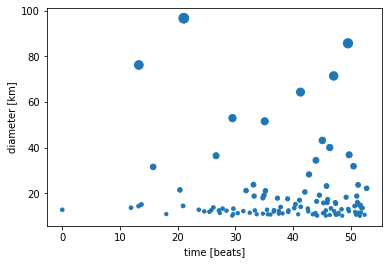

In [35]:
#calculate duration in seconds
bpm = 60  #if bpm = 60, 1 beat = 1 sec 
duration_sec = duration_beats*60/bpm #duration in seconds (actually, onset of last note)
print('Duration:', duration_sec, 'seconds')


plt.scatter(t_data, diameters, s=diameters)
plt.xlabel('time [beats]')
plt.ylabel('diameter [km]')
plt.show()

## 4) Normalize and scale data

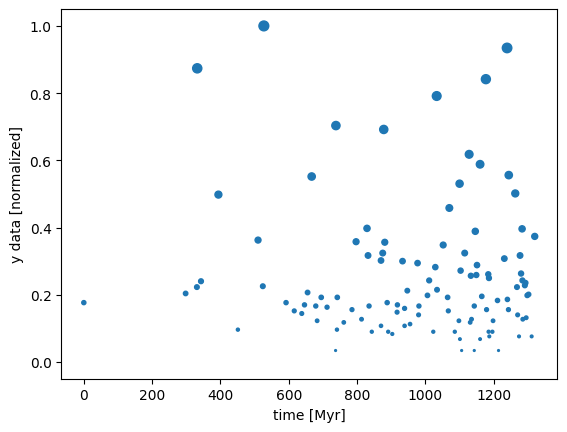

In [11]:

y_data = map_value(diameters, min(diameters), max(diameters), 0, 1) #normalize data, so it runs from 0 to 1 

y_scale = 0.5  #lower than 1 to spread out more evenly

y_data = y_data**y_scale

plt.scatter(times_myrs, y_data, s=50*y_data)
plt.xlabel('time [Myr]')
plt.ylabel('y data [normalized]')
plt.show()


## 6) Choose musical notes for pitch mapping, convert to midi numbers
- choose the set of musical notes to map data to (it's common to use a few octaves of a certain scale but you can choose any set of notes you want depending on your goals for the sonification)
- the total number of notes sets the pitch resolution, think of this as the number of rows of pixels in an image
- these note names are converted to [midi note numbers](https://www.inspiredacoustics.com/en/MIDI_note_numbers_and_center_frequencies ) (integers from 0 to 127, lowest note on piano = A0 = 21, C1 = 24, etc.)

<br>
<div> <img src="figures/midi.png" alt="MIDI Note numbers" width="600"/></div>
<br>

(from [Müller, FMP, Springer 2015](https://www.audiolabs-erlangen.de/fau/professor/mueller/bookFMP))

In [17]:
import itertools as it
from numpy import NaN


MIDI_A4 = 69

def str2midi(note_string):
  """
  Given a note string name (e.g. "Bb4"), returns its MIDI pitch number.
  """
  if note_string == "?":
    return NaN
  data = note_string.strip().lower()
  name2delta = {"c": -9, "d": -7, "e": -5, "f": -4, "g": -2, "a": 0, "b": 2}
  accident2delta = {"b": -1, "#": 1, "x": 2}
  accidents = list(it.takewhile(lambda el: el in accident2delta, data[1:]))
  octave_delta = int(data[len(accidents) + 1:]) - 4
  return (MIDI_A4 +
          name2delta[data[0]] + # Name
          sum(accident2delta[ac] for ac in accidents) + # Accident
          12 * octave_delta # Octave
         )

In [19]:
# from audiolazy import str2midi #import function to convert note names to midi numbers (could also use: midi2str, str2freq, freq2str,freq2midi,midi2freq) https://pypi.org/project/audiolazy/

# # 4 octaves of major scale
# note_names = ['C2','D2','E2','F2','G2','A2','B2',
#              'C3','D3','E3','F3','G3','A3','B3',
#              'C4','D4','E4','F4','G4','A4','B4',
#              'C5','D5','E5','F5','G5','A5','B5']

# #4 octaves of major pentatonic scale 
# note_names = ['C2','D2','E2','G2','A2',
#              'C3','D3','E3','G3','A3',
#              'C4','D4','E4','G4','A4',
#              'C5','D5','E5','G5','A5']

#custom note set (a voicing of a Cmaj13#11 chord, notes from C lydian)
note_names = ['C1','C2','G2',
             'C3','E3','G3','A3','B3',
             'D4','E4','G4','A4','B4',
             'D5','E5','G5','A5','B5',
             'D6','E6','F#6','G6','A6']

note_midis = [str2midi(n) for n in note_names] #make a list of midi note numbers 

print(note_midis)

n_notes = len(note_midis)
print('Resolution:',n_notes, 'notes')

[24, 36, 43, 48, 52, 55, 57, 59, 62, 64, 67, 69, 71, 74, 76, 79, 81, 83, 86, 88, 90, 91, 93]
Resolution: 23 notes


## 7) Map data to MIDI note numbers (map larger craters to lower notes)

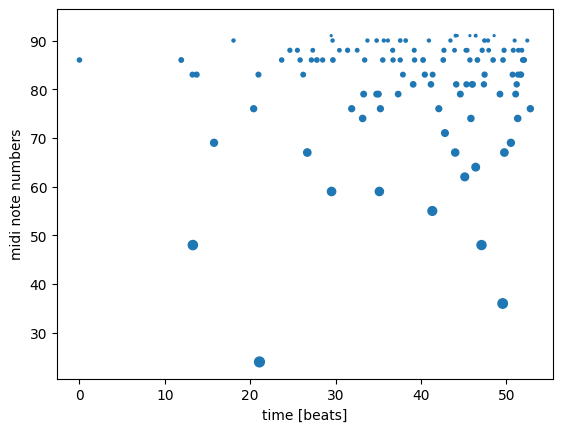

In [21]:
midi_data = []
for i in range(n_impacts):
    note_index = round(map_value(y_data[i], 0, 1, n_notes-1, 0)) #notice choice of polarity: bigger craters are mapped to lower notes
                                                        #we round the result because it's a list index which must be an integer
    midi_data.append(note_midis[note_index])

plt.scatter(t_data, midi_data, s=50*y_data)
plt.xlabel('time [beats]')
plt.ylabel('midi note numbers')
plt.show()



## 8) Map data to note velocities (map larger craters to greater velocities)
- midi velocity (integer from 0-127) is a combination of volume and intensity (hitting a piano key with a larger velocity makes a louder, more intense sound)
- we are using the same data to control the note pitch and the note velocity (this is called 'dual coding')

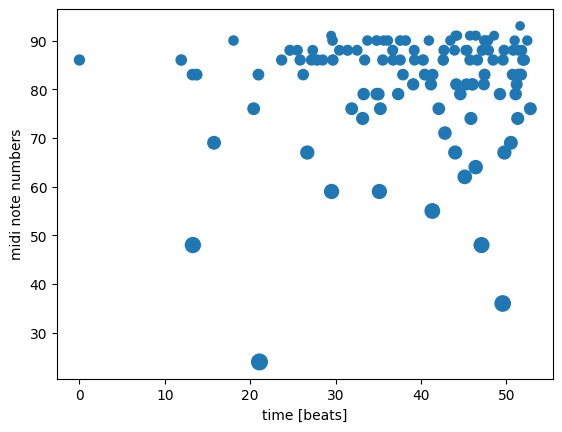

In [22]:
vel_min,vel_max = 35,127   #minimum and maximum note velocity

vel_data = []
for i in range(n_impacts):
    note_velocity = round(map_value(y_data[i], 0, 1, vel_min, vel_max)) #bigger craters will be louder
                                                                #we round here because note velocites are integers
    vel_data.append(note_velocity)
    
plt.scatter(t_data, midi_data, s=vel_data)
plt.xlabel('time [beats]')
plt.ylabel('midi note numbers')
plt.show()

## 9) Save data as MIDI file

In [24]:
from midiutil import MIDIFile #import library to make midi file, https://midiutil.readthedocs.io/en/1.2.1/

bpm = 60
#create midi file object, add tempo
my_midi_file = MIDIFile(1) #one track 
my_midi_file.addTempo(track=0, time=0, tempo=bpm) 

#add midi notes
for i in range(n_impacts):
    my_midi_file.addNote(track=0, channel=0, pitch=midi_data[i], time=t_data[i], duration=2, volume=vel_data[i])

#create and save the midi file itself
with open(filename + '.mid', "wb") as f:
    my_midi_file.writeFile(f) 


## Optional: Listen to MIDI file within jupyter

In [25]:
# import sys 
# !{sys.executable} -m pip install --quiet "pygame"  #install pygame with pip
# #or use this if you installed python with anaconda
# #conda install --yes --prefix {sys.prefix} pygame

import pygame #import library for playing midi files, https://pypi.org/project/pygame/

pygame.init()
pygame.mixer.music.load(filename + '.mid')
pygame.mixer.music.play()



pygame 2.5.2 (SDL 2.28.2, Python 3.10.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


error: Couldn't open timidity.cfg

In [ ]:
pygame.mixer.music.stop()

## Next Steps
- open MIDI file in DAW (Digital Audio Workstation) like Logic, Garageband, Ableton, ProTools,...
- choose instruments/sounds
- add effects and/or other layers
- [check out part 2 on Gumroad!](https://astromattrusso.gumroad.com/l/data2music-part2)